# DCTによる圧縮画像を作る

In [118]:
import numpy as np
import scipy.misc
from scipy.fftpack import dct, idct
import sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
from scipy.fftpack import dct, idct
import seaborn as sns
from skimage.metrics import structural_similarity as ssim

%matplotlib inline


class ImageLoader:
    def __init__(self, FILE_PATH):
        self.img = np.array(Image.open(FILE_PATH))
        # 行数
        self.row_blocks_count = self.img.shape[0] // 8
        # 列数
        self.col_blocks_count = self.img.shape[1] // 8

    def get_points(self, POINT):
        Row = random.randint(0, len(self.img) - POINT - 1)
        Col = random.randint(0, len(self.img) - 1)
        return self.img[Row : Row + POINT, Col]

    def get_block(self, col, row):
        return self.img[col * 8 : (col + 1) * 8, row * 8 : (row + 1) * 8]


# plt.rcParams['font.family'] ='sans-serif'#使用するフォント
# plt.rcParams["font.sans-serif"] = "Source Han Sans"
plt.rcParams["font.family"] = "Source Han Sans JP"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 12  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
matplotlib.font_manager._rebuild()

# 画像の用意
MONO_DIR_PATH = "../Mono/"
AIRPLANE = ImageLoader(MONO_DIR_PATH + "airplane512.bmp")
BARBARA = ImageLoader(MONO_DIR_PATH + "barbara512.bmp")
BOAT = ImageLoader(MONO_DIR_PATH + "boat512.bmp")
BRIDGE = ImageLoader(MONO_DIR_PATH + "BRIDGE.bmp")
BUILDING = ImageLoader(MONO_DIR_PATH + "Building.bmp")
CAMERAMAN = ImageLoader(MONO_DIR_PATH + "Cameraman.bmp")
GIRL = ImageLoader(MONO_DIR_PATH + "girl.bmp")
LAX = ImageLoader(MONO_DIR_PATH + "LAX.bmp")
LENNA = ImageLoader(MONO_DIR_PATH + "lenna512.bmp")
LIGHTHOUSE = ImageLoader(MONO_DIR_PATH + "Lighthouse.bmp")
MILKDROP = ImageLoader(MONO_DIR_PATH + "milkdrop512.bmp")
SIDBAtitle = ImageLoader(MONO_DIR_PATH + "SIDBAtitle256.bmp")
TEXT = ImageLoader(MONO_DIR_PATH + "Text.bmp")
WOMAN = ImageLoader(MONO_DIR_PATH + "WOMAN.bmp")

Images = np.array(
    [
        AIRPLANE,
        BARBARA,
        BOAT,
        BRIDGE,
        BUILDING,
        CAMERAMAN,
        GIRL,
        LAX,
        LENNA,
        LIGHTHOUSE,
        SIDBAtitle,
        TEXT,
        WOMAN,
    ]
)

N = 8

# DCT

## 基底関数

$$
\phi_k[i] = \begin{cases}
\cfrac{1}{\sqrt{N}}  \quad \quad \quad (k=0) \\
\sqrt{\cfrac{2}{N}} \cos \left({\cfrac{\pi}{2N}(2i+1)k}\right) \quad  (k=1,2,...,N-1) 
\end{cases}
$$

In [119]:
class DCT:
    def __init__(self, N):
        self.N = N  # データ数
        # 1次元DCTの基底ベクトルの生成
        self.phi_1d = np.array([self.phi(i) for i in range(self.N)])
        # 2次元DCTの基底ベクトルの格納
        self.phi_2d = np.zeros((N, N))

    def phi(self, k):
        """ 離散コサイン変換(DCT)の基底関数 """
        # DCT-II
        if k == 0:
            return np.ones(self.N) / np.sqrt(self.N)
        else:
            return np.sqrt(2.0 / self.N) * np.cos(
                (k * np.pi / (2 * self.N)) * (np.arange(self.N) * 2 + 1)
            )

    def dct(self, data):
        """ 1次元離散コサイン変換を行う """
        return self.phi_1d.dot(data)

    def idct(self, c):
        """ 1次元離散コサイン逆変換を行う """
        return np.sum(self.phi_1d.T * c, axis=1)

    def get_dct2_phi(self, y, x):
        """ 2次元離散コサイン変換の基底を返す """
        phi_x, phi_y = np.meshgrid(self.phi_1d[x], self.phi_1d[y])
        return phi_x * phi_y

    def get_dct2(self, y, x, data):
        """ i,jの2次元DCT係数を返す """
        phi_2d_phi = np.zeros((self.N, self.N))
        phi_2d_phi = self.get_dct2_phi(y, x)
        return np.sum(np.sum(phi_2d_phi * data))

    def dct2(self, data):
        """ 2次元離散コサイン変換を行う """
        for y in range(self.N):
            for x in range(self.N):
                self.phi_2d[y, x] = self.get_dct2(y, x, data)

        return self.phi_2d

    def idct2(self, c):
        """ 2次元離散コサイン逆変換を行う """
        idct2_data = np.zeros((self.N, self.N))
        phi_2d_phi = np.zeros((self.N, self.N))
        for y in range(self.N):
            for x in range(self.N):
                phi_2d_phi = self.get_dct2_phi(y, x)
                idct2_data += c[y, x] * phi_2d_phi

        return idct2_data

# 8x8ブロックでDCT

### DCT

In [120]:
IMG = MILKDROP

In [121]:
Fk = np.zeros(IMG.img.shape)

In [122]:
for row in range(IMG.img.shape[0] // 8):
    for col in range(IMG.img.shape[1] // 8):
        block = IMG.img[row * 8 : (row + 1) * 8, col * 8 : (col + 1) * 8]
        c = scipy.fftpack.dct(
            scipy.fftpack.dct(block, axis=0, norm="ortho"), axis=1, norm="ortho"
        )
        Fk[row * 8 : (row + 1) * 8, col * 8 : (col + 1) * 8] = c

In [123]:
low_3_value = 0
others_value = 0

In [124]:
for row in range(IMG.img.shape[0] // 8):
    for col in range(IMG.img.shape[1] // 8):
        block = Fk[row * 8 : (row + 1) * 8, col * 8 : (col + 1) * 8]
        low_3_value += np.abs(block[0, 1]) + np.abs(block[1, 0]) + np.abs(block[1, 1])
        others_value += (
            np.sum(np.sum(np.abs(block)))
            - np.abs(block[0, 0])
            - np.abs(block[0, 1])
            - np.abs(block[1, 0])
            - np.abs(block[1, 1])
        )

### 低域3成分 (0,1)(1,0)(1,1)の絶対値の和

In [125]:
low_3_value

270310.2149909486

In [126]:
others_value

762427.4965735098

### IDCT

In [127]:
recover = np.zeros(Fk.shape)

In [128]:
for row in range(Fk.shape[0] // 8):
    for col in range(Fk.shape[1] // 8):
        block = Fk[row * 8 : (row + 1) * 8, col * 8 : (col + 1) * 8]
        data = scipy.fftpack.idct(
            scipy.fftpack.idct(block, axis=0, norm="ortho"), axis=1, norm="ortho"
        )
        recover[row * 8 : (row + 1) * 8, col * 8 : (col + 1) * 8] = data

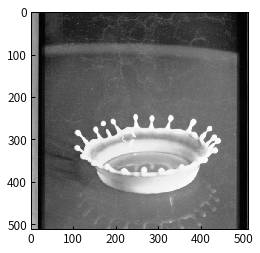

In [129]:
plt.imshow(recover, cmap="gray")

In [130]:
recover[0, 0:10]

array([ 21., 135., 140., 143., 141., 142., 146., 149., 149., 146.])

In [131]:
IMG.img[0, 0:10]

array([ 21, 135, 140, 143, 141, 142, 146, 149, 149, 146], dtype=uint8)

ちゃんと復元できてる

# 量子化テーブル

In [132]:
Q50_Luminance = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ]
)

$$
S = (Q < 50)?\frac{5000}{Q}:200-2Q\\
Q_s[i] = \left[\frac{S\times Q_b[i]+50}{100}\right]
$$

In [200]:
# Q=80における量子化テーブルをスケーリング
Q = 35.7
if Q < 50:
    S = 5000 / Q
else:
    S = 200 - 2 * Q

S = np.floor(S)

Q_Luminance = np.zeros((8, 8))
for row in range(8):
    for col in range(8):
        Q_Luminance[row, col] = np.floor((S * Q50_Luminance[row, col] + 50) / 100)

# 量子化

In [201]:
Q_Fk = np.zeros(Fk.shape)

In [202]:
for row in range(IMG.img.shape[0] // 8):
    for col in range(IMG.img.shape[1] // 8):
        block = Fk[row * 8 : (row + 1) * 8, col * 8 : (col + 1) * 8]
        # 量子化
        block = np.round(block / Q_Luminance)
        # 逆量子化
        block = block * Q_Luminance
        Q_Fk[row * 8 : (row + 1) * 8, col * 8 : (col + 1) * 8] = block

# IDCT

In [203]:
Q_recover = np.zeros(Q_Fk.shape)

In [204]:
for row in range(Q_Fk.shape[0] // 8):
    for col in range(Q_Fk.shape[1] // 8):
        block = Q_Fk[row * 8 : (row + 1) * 8, col * 8 : (col + 1) * 8]
        data = scipy.fftpack.idct(
            scipy.fftpack.idct(block, axis=0, norm="ortho"), axis=1, norm="ortho"
        )
        Q_recover[row * 8 : (row + 1) * 8, col * 8 : (col + 1) * 8] = data

In [205]:
Q_recover = np.round(Q_recover)

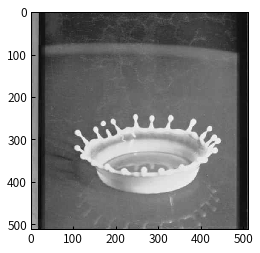

In [206]:
plt.imshow(Q_recover, cmap="gray")

In [207]:
# Q_recover[0]

# 情報量

$$
- \sum ^{255}_{i=0} p_i log_2 p_i
$$

In [208]:
import pandas as pd
qfk = pd.Series(Q_Fk.flatten())
pro = qfk.value_counts() / qfk.value_counts().sum()
pro.head()

-0.0     0.937817
-17.0    0.003658
 17.0    0.003242
-20.0    0.003155
 20.0    0.003136
dtype: float64

In [209]:
S = 0
for pi in pro:
    S -= pi * np.log2(pi)

In [210]:
S

0.745290745218865

# PSNR

$$
PSNR = 10 log_{10} \frac{MAX^2}{MSE}
$$

$$
{MSE = \frac{1}{m \, n} \sum^{m-1}_{i=0} \sum^{n-1}_{j=0} [ I(i,j) - K(i,j) ]^2}
$$

In [211]:
MSE = np.sum(np.sum(np.power((IMG.img - Q_recover), 2))) / (
    Q_Fk.shape[0] * Q_Fk.shape[1]
)

In [212]:
PSNR = 10 * np.log10(255 * 255 / MSE)

In [213]:
PSNR

36.964153099185296

# MSSIM

In [214]:
ssim(IMG.img,Q_recover.astype(IMG.img.dtype),gaussian_weights=True,sigma=1.5,K1=0.01,K2=0.03)

0.8994031165764934

# MSDS

In [215]:
w_e = 0
e_e = 0
n_e = 0
s_e = 0
nw_e = 0
ne_e = 0
sw_e = 0
se_e = 0
for row in range(Q_recover.shape[0] // 8):
    for col in range(Q_recover.shape[1] // 8):
        f_block = Q_recover[row * 8 : (row + 1) * 8, col * 8 : (col + 1) * 8]
        # w
        if col == 0:
            w_block = np.fliplr(f_block)
        else:
            w_block = Q_recover[row * 8 : (row + 1) * 8, (col - 1) * 8 : col * 8]
        # e
        if col == Q_recover.shape[1] // 8 - 1:
            e_block = np.fliplr(f_block)
        else:
            e_block = Q_recover[row * 8 : (row + 1) * 8, (col + 1) * 8 : (col + 2) * 8]
        # n
        if row == 0:
            n_block = np.flipud(f_block)
        else:
            n_block = Q_recover[(row - 1) * 8 : row * 8, col * 8 : (col + 1) * 8]
        # s
        if row == Q_recover.shape[0] // 8 - 1:
            s_block = np.flipud(f_block)
        else:
            s_block = Q_recover[(row + 1) * 8 : (row + 2) * 8, col * 8 : (col + 1) * 8]

        w_d1 = f_block[:, 0] - w_block[:, 7]
        e_d1 = f_block[:, 7] - e_block[:, 0]
        n_d1 = f_block[0, :] - n_block[7, :]
        s_d1 = f_block[7, :] - s_block[0, :]

        w_d2 = (w_block[:, 7] - w_block[:, 6] + f_block[:, 1] - f_block[:, 0]) / 2
        e_d2 = (e_block[:, 1] - e_block[:, 0] + f_block[:, 7] - f_block[:, 6]) / 2
        n_d2 = (n_block[7, :] - n_block[6, :] + f_block[1, :] - f_block[0, :]) / 2
        s_d2 = (s_block[1, :] - s_block[0, :] + f_block[7, :] - f_block[6, :]) / 2

        w_e += np.sum((w_d1 - w_d2) ** 2 )
        e_e += np.sum((e_d1 - e_d2) ** 2 )
        n_e += np.sum((n_d1 - n_d2) ** 2)
        s_e += np.sum((s_d1 - s_d2) ** 2)
        
        # nw
        if row == 0 or col == 0:
            nw_block = np.flipud(np.fliplr(f_block))
        else:
            nw_block = Q_recover[(row - 1) * 8 : row * 8, (col - 1) * 8 : col * 8]
        # ne
        if row == 0 or col == Q_recover.shape[1] // 8 - 1:
            ne_block = np.flipud(np.fliplr(f_block))
        else:
            ne_block = Q_recover[(row-1) * 8 : row * 8, (col + 1) * 8 : (col + 2) * 8]
        # sw
        if row == Q_recover.shape[0] // 8 -1 or col == 0:
            sw_block = np.flipud(np.fliplr(f_block))
        else:
            sw_block = Q_recover[row * 8 : (row+1) * 8, (col-1) * 8 : col * 8]
        # se
        if  row == Q_recover.shape[0]//8-1 or col == Q_recover.shape[0] // 8 -1:
            se_block = np.flipud(np.fliplr(f_block))
        else:
            se_block = Q_recover[(row + 1) * 8 : (row + 2) * 8, (col+1) * 8 : (col + 2) * 8]

        nw_g1 = f_block[0, 0] - nw_block[7, 7]
        ne_g1 = f_block[0, 7] - ne_block[7, 0]
        sw_g1 = f_block[7, 0] - sw_block[0, 7]
        se_g1 = f_block[7, 7] - se_block[0, 0]

        nw_g2 = (nw_block[7,7] - nw_block[6,6] + f_block[1,1] - f_block[0,0])/2
        ne_g2 = (ne_block[7,0] - ne_block[6,1] + f_block[1,6] - f_block[0,7])/2
        sw_g2 = (sw_block[0,7] - nw_block[1,6] + f_block[6,1] - f_block[7,0])/2
        se_g2 = (nw_block[0,0] - nw_block[1,1] + f_block[6,6] - f_block[7,7])/2

        nw_e += (nw_g1 - nw_g2) ** 2 
        ne_e += (ne_g1 - ne_g2) ** 2 
        sw_e += (sw_g1 - sw_g2) ** 2 
        se_e += (se_g1 - se_g2) ** 2 

MSDSt = (w_e + e_e + n_e + s_e + nw_e + ne_e + sw_e + se_e)/ ((512/8)**2)
MSDS1 = (w_e + e_e + n_e + s_e)/ ((512/8)**2)
MSDS2 = (nw_e + ne_e + sw_e + se_e)/ ((512/8)**2)

In [216]:
MSDS1

2632.773681640625

In [217]:
MSDS2

1228.5337524414062